In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import math
from scipy.optimize import curve_fit
import functions as model2
from cmdstanpy import CmdStanModel

In [2]:

def hazard_function_empirical_protein(df):
    protein_levels = np.asarray(df["protein_level"], dtype=float)
    protein_levels = protein_levels[np.isfinite(protein_levels)]
    protein_levels = np.sort(protein_levels)
    min_diff = 0.0001
    N_t = len(protein_levels)
    p_max = np.max(protein_levels)
    grid = np.arange(0, p_max + min_diff, min_diff)
    survival = [(protein_levels > p).sum()/N_t for p in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for p in range(len(grid) - 1):
        if survival[p] > 0 and survival[p+1] > 0:   #Checking division by zero
            hazard[p] = - (np.log(survival[p+1]) - np.log(survival[p])) / (grid[p+1] - grid[p])
        else:
            hazard[p] = 0
    return grid, hazard/sum(hazard), survival[:-1]


def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)

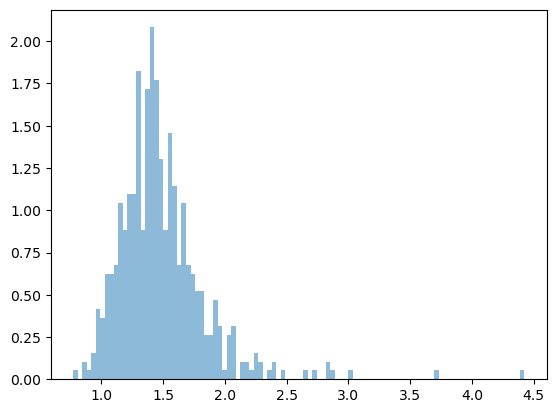

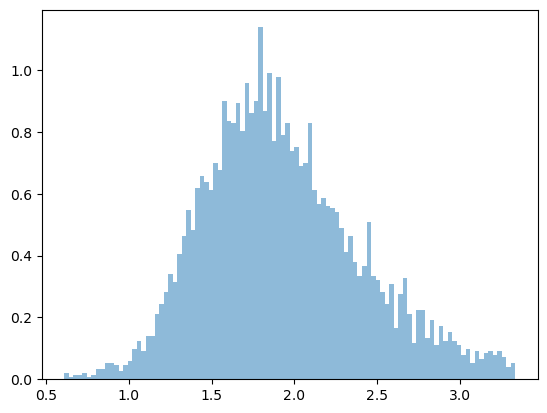

In [5]:
#Make a dictionary of dataframes
dfs = {}
names = []                                              
for path in glob.glob("data/*.csv"):
    if path=="data/UMIK_allSources.csv" or path=="data/df_UMIK_allSources.csv":
        continue
    name = os.path.splitext(os.path.basename(path))[0]  
    names.append(name)
    dfs[name] = pd.read_csv(path)

# Add protein levels to the dataframes
for name, df in dfs.items():
    df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])
# We used lenght instead of mass


clean_ace = dfs['UMIK_Ace'].dropna()


q1, q3 = clean_ace['protein_level'].quantile([0.25, 0.75])
iqr           = q3 - q1
lower_fence   = q1 - 1.5 * iqr
upper_fence   = q3 + 1.5 * iqr

# 4. Keep only non-outliers
clean_no_outliers = clean_ace[(clean_ace['protein_level'] >= lower_fence) & (clean_ace['protein_level'] <= upper_fence)]

# 5. (Optional) assign back to your DataFrame
df_clean_Ace = df.loc[clean_no_outliers.index].copy()
dfs['UMIK_Ace'] = df_clean_Ace
plt.figure()
plt.hist(df_clean_Ace['protein_level'], bins=100, density=True, alpha=0.5, label='Cleaned Protein Levels')
plt.show()

clean_lac = dfs['UMIK_Lac'].dropna()
q1, q3 = clean_lac['protein_level'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr
# Keep only non-outliers
clean_lac_no_outliers = clean_lac[(clean_lac['protein_level'] >= lower_fence) & (clean_lac['protein_level'] <= upper_fence)]
dfs['UMIK_Lac'] = clean_lac_no_outliers

plt.figure()
plt.hist(clean_lac_no_outliers['protein_level'], bins=100, density=True, alpha=0.5, label='Cleaned Lac Protein Levels')
plt.show()

1
2
3
4
5
6
7
8
9


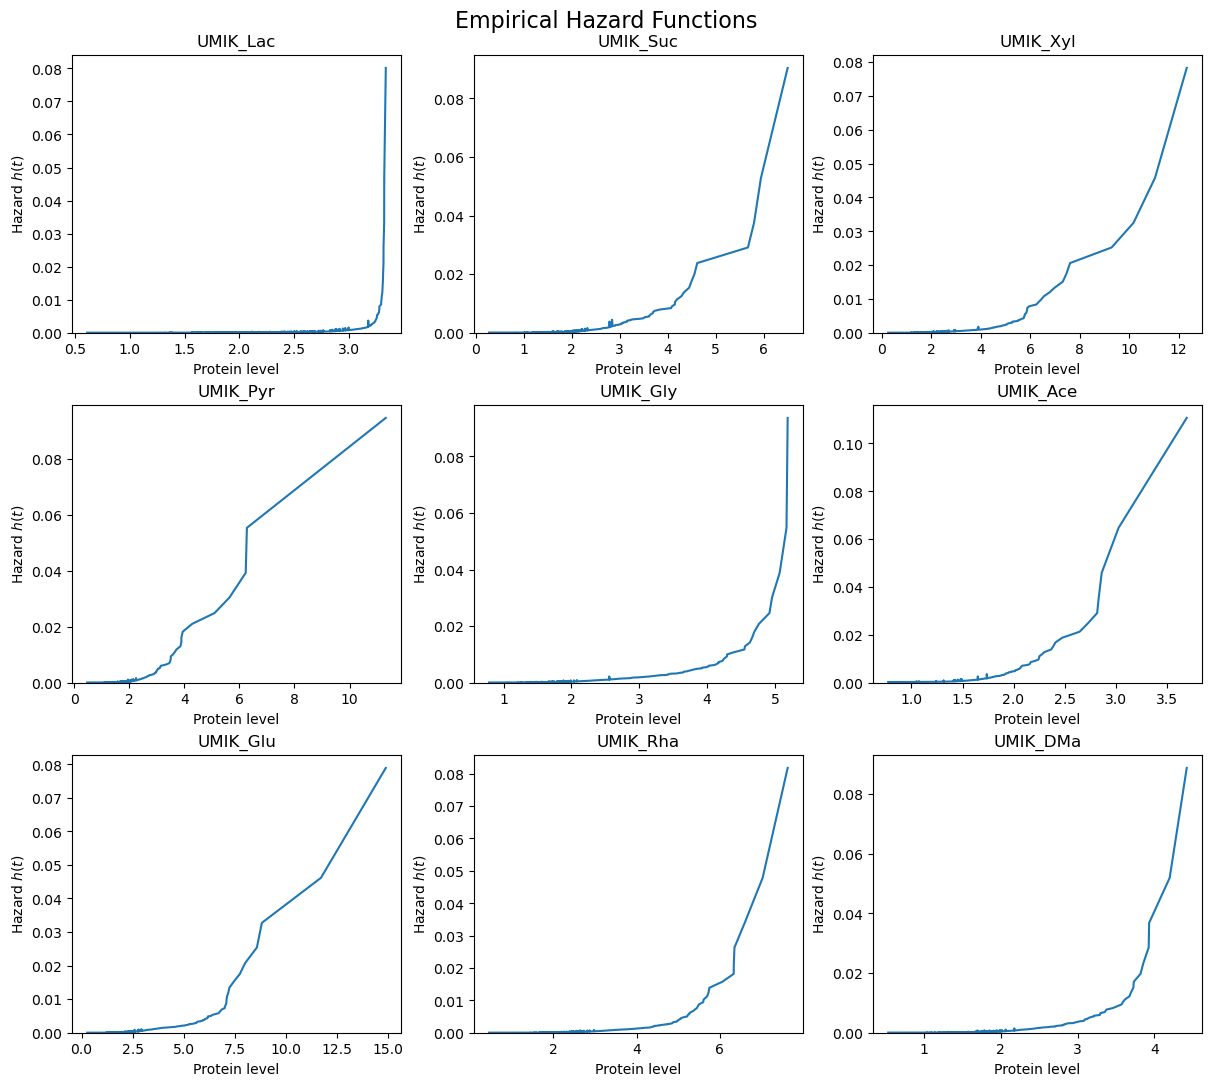

In [6]:
hazards = []
i = 0                         
for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))
    i += 1
    print(i)

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):

    """#remove extreme values
    if name == "UMIK_Ace":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]
    elif name == "UMIK_Pyr":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]"""

    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Hazard $h(t)$")
    ax.set_ylim(bottom=0)

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()

In [7]:
def logistic_survival(t, a, b):
    return 1 / (1 + np.exp(a * (t - b)))

def generalized_logistic_survival(t, tau, k, alpha):
    return 1 / (1 + (t / tau)**k)**alpha

def generalized_logistic_hazard(t, tau, k, alpha):
    t = np.asarray(t)
    term = (t / tau)
    numerator = alpha * k / tau * term**(k - 1)
    denominator = 1 + term**k
    return numerator / denominator

# Survival and Hazard funciton as a funcion of protein level

$S(p) = \frac{1}{\left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a}}$

$h(p) = \frac{a k}{\tau^k} \cdot \frac{p^{k-1}}{1 + \left( \frac{p}{\tau} \right)^k}$

$f(p) = \frac{a \cdot k \cdot p^{k-1}}{\tau^k \left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a + 1}}$

$p$: independent variable (protein level)

$\tau$: inflection point (location)

$k$: shape/steepness

$a$: scale or tail weight parameter

# Survival and Hazard funciton as a funcion of time

$p(t) = c m_D \left(e^{\alpha t} - 1\right)$ : Protein growth as a function of time $t$


$S(t) = \frac{1}{\left(1 + \left( \frac{c m_D (e^{\alpha t} - 1)}{\tau} \right)^k \right)^{\alpha}}$

$h(t) = \left[ \frac{\alpha k}{\tau} \cdot \frac{\left( \frac{p(t)}{\tau} \right)^{k-1}}{1 + \left( \frac{p(t)}{\tau} \right)^k} \right] \cdot c m_D \alpha e^{\alpha t}$

UMIK_Lac
UMIK_Suc
UMIK_Xyl
UMIK_Pyr
UMIK_Gly
UMIK_Ace
UMIK_Glu
UMIK_Rha
UMIK_DMa


/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_13034/2431327484.py:5: RuntimeWarning: divide by zero encountered in power
  return 1 / (1 + (t / tau)**k)**alpha
/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_13034/2431327484.py:5: RuntimeWarning: invalid value encountered in power
  return 1 / (1 + (t / tau)**k)**alpha


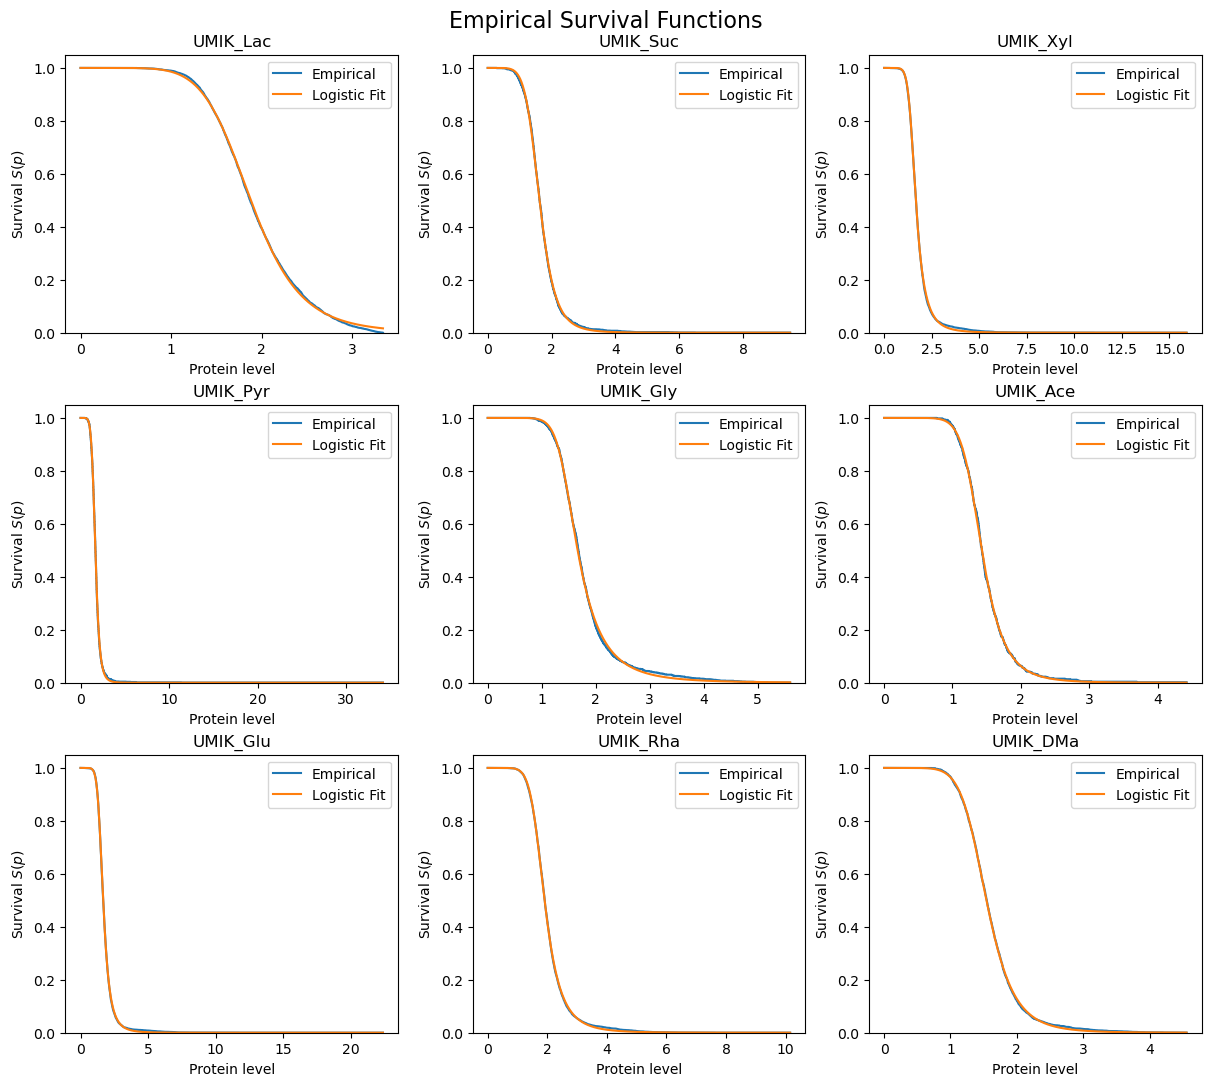

In [8]:
hazards = []                         

for name, df in dfs.items():
    print(name)         
    grid, h, survival = hazard_function_empirical_protein(df)
    hazards.append((name, grid[:-1], h, survival))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               
fittingParams = []

for ax, (name, grid, h, survival) in zip(axes, hazards):

    popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
    grid_fit = np.linspace(min(grid), max(grid), len(grid))
    survival_fit = generalized_logistic_survival(grid_fit, *popt)
    fittingParams.append(popt)
    
    ax.plot(grid, survival, lw=1.5, label='Empirical')
    ax.plot(grid_fit, survival_fit, label='Logistic Fit')

    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Survival $S(p)$")
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Survival Functions", fontsize=16, y=1.02)
plt.show()

fittingParams = pd.DataFrame(fittingParams)
fittingParams.columns = ["T", "k", "a"]

In [9]:
fittingParams

,T,k,a
0,1.920109,6.635224,1.111569
1,1.627657,6.696428,1.008733
2,1.503152,9.208714,0.543765
3,1.695653,6.883056,1.060456
4,1.486254,9.993666,0.487834
5,1.366496,9.794095,0.736768
6,1.545852,8.271839,0.644072
7,1.777183,8.197721,0.675184
8,1.520967,7.687937,0.926973


Text(0.5, 1.0, 'Fitting parameters')

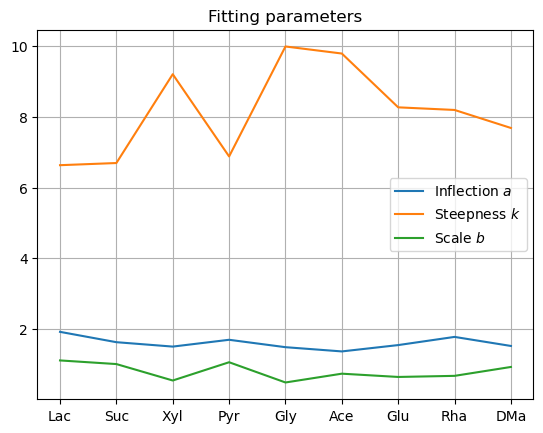

In [10]:
sugars = ["Lac", "Suc", "Xyl", "Pyr", "Gly", "Ace", "Glu", "Rha", "DMa"]

plt.plot(fittingParams["T"], label ='Inflection $a$')
plt.plot(fittingParams["k"], label ='Steepness $k$')
plt.plot(fittingParams["a"], label ='Scale $b$')

plt.legend()
plt.grid()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8], labels = sugars)
plt.title("Fitting parameters")

Text(0.5, 1.0, 'Scatter Plot of Fitting Parameters T - k')

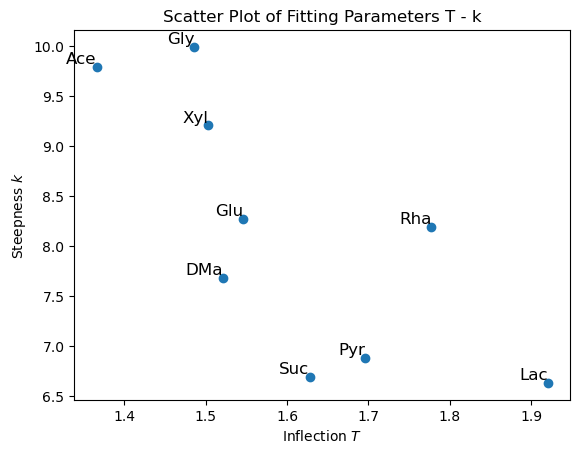

In [11]:
T = fittingParams["T"]
k = fittingParams["k"]
a = fittingParams["a"]

plt.scatter(T,k)
for i, label in enumerate(sugars):
    plt.text(T[i], k[i], label, fontsize=12, ha='right', va='bottom')
plt.xlabel('Inflection $T$')
plt.ylabel('Steepness $k$')
plt.title('Scatter Plot of Fitting Parameters T - k')

# Hazard function from survial fit (DMa)

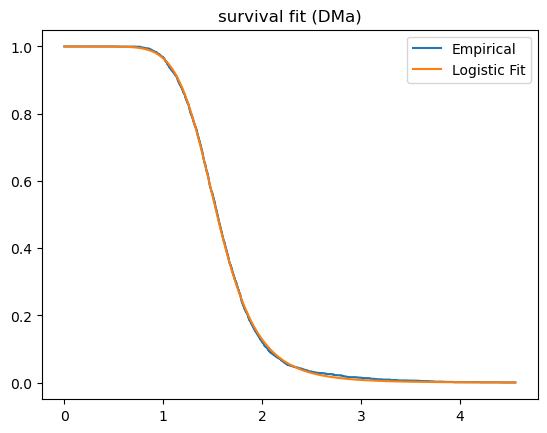

In [12]:
plt.plot(grid, survival, lw=1.5, label='Empirical')
plt.plot(grid_fit, survival_fit, label='Logistic Fit')
plt.title("survival fit (DMa)")
plt.legend()

In [13]:
hazard = np.empty(len(grid)-1, dtype=float)
for p in range(len(grid) - 1):
    if survival_fit[p] > 0 and survival_fit[p+1] > 0:
        hazard[p] = - (np.log(survival_fit[p+1]) - np.log(survival_fit[p])) / (grid_fit[p+1] - grid_fit[p])
    else:
        hazard[p] = 0

Text(0.5, 1.0, 'hazard from survival fit (DMa)')

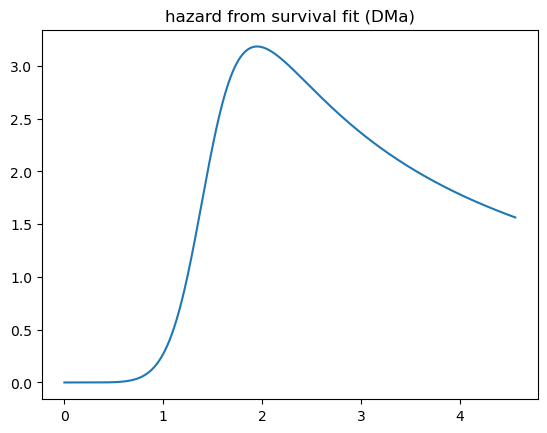

In [14]:
plt.plot(grid_fit[:-1],hazard)
plt.title("hazard from survival fit (DMa)")

In [15]:
def protein_levels_at_division_pdf(p, alpha, k, tau):
    # Compute the probability density function (PDF) of the protein levels
    return (alpha * k/(tau**k)) * (p**(k-1)) / ((1 + (p/tau)**k)**(alpha + 1))


In [16]:
def metropolis_hastings(unnorm_pdf, alpha, k, tau, n_samples=100000, proposal_width=1.0, burn_in=50000):
    samples = []
    p_current = np.random.rand() + 0.1  # initial value > 0
    for _ in range(n_samples + burn_in):
        p_proposal = np.random.normal(p_current, proposal_width)
        if p_proposal <= 0:
            continue  # stay in domain

        # Acceptance probability
        p_accept = min(1, unnorm_pdf(p_proposal, alpha, k, tau) / unnorm_pdf(p_current, alpha, k, tau))

        if np.random.rand() < p_accept:
            p_current = p_proposal

        samples.append(p_current)

    return np.array(samples[burn_in:])



### Sampling with determistic parameters

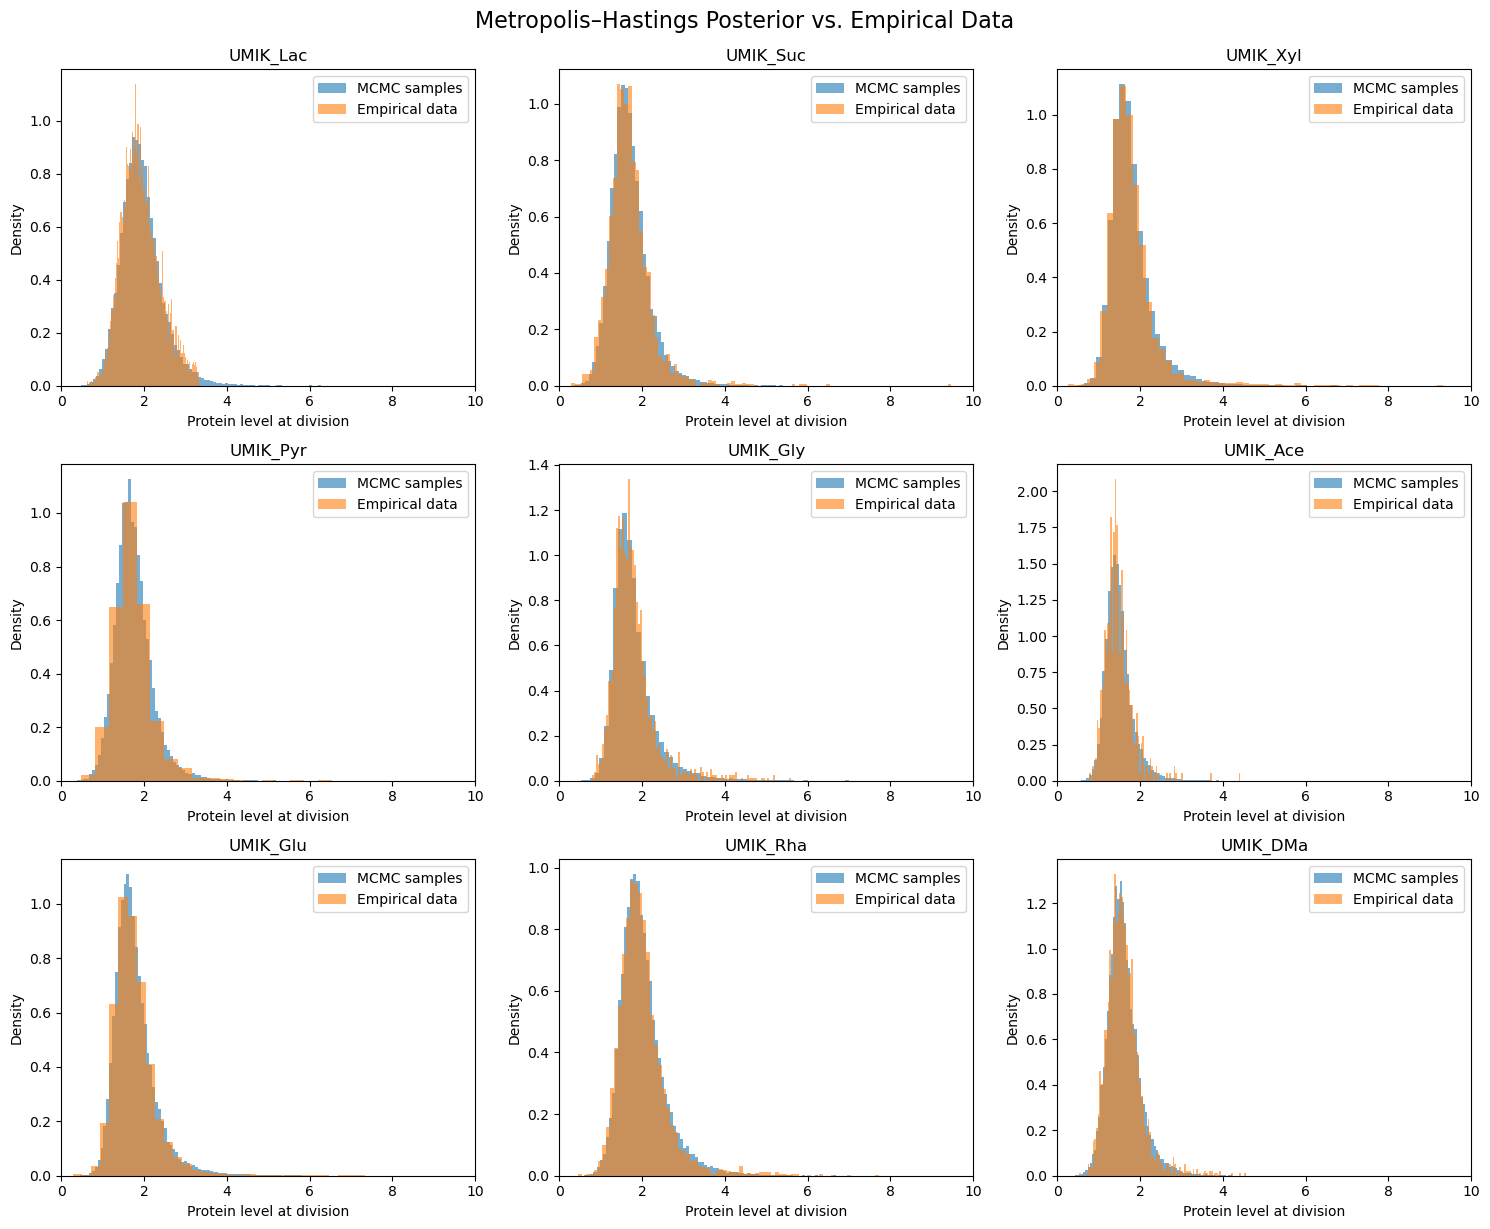

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # 3x3 grid
axs = axs.flatten()  # flatten so we can index as a list

for i in range(len(fittingParams['a'])):
    alpha = fittingParams['a'][i]
    k = fittingParams['k'][i]
    tau = fittingParams['T'][i]

    samples = metropolis_hastings(protein_levels_at_division_pdf, alpha, k, tau)
    posterior_samples = samples
    empirical_protein_level = dfs[names[i]]["protein_level"].dropna()

    ax = axs[i]
    ax.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
    ax.hist(empirical_protein_level, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')
    ax.set_xlim(0, 10)
    ax.set_title(f"{names[i]}")
    ax.set_xlabel("Protein level at division")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.suptitle("Metropolis–Hastings Posterior vs. Empirical Data", fontsize=16, y=1.02)
plt.show()


In [18]:
empirical_protein_level = dfs["UMIK_Ace"]["protein_level"]
empirical_protein_level = np.sort(empirical_protein_level)
d = np.diff(empirical_protein_level, n=1)
print(np.sort(d[:10]))
print(np.sum(d[~np.isnan(d)]))
empirical_protein_level = dfs["UMIK_Gly"]["protein_level"]
empirical_protein_level = np.sort(empirical_protein_level)
d = np.diff(empirical_protein_level, n=1)
print(np.sort(d[:10]))
print(np.sum(d[~np.isnan(d)]))


[0.00074004 0.00186422 0.00300076 0.00421314 0.00423501 0.00490501
 0.01937628 0.0338381  0.04180335 0.08234131]
3.6517936517659324
[0.00178037 0.00260428 0.00268458 0.00915046 0.01064725 0.01480817
 0.01784696 0.02142741 0.021604   0.03424969]
4.816996962509291
